# Final Project Submission

Please fill out:
* Student name: **Brian Bentson**
* Student pace: self paced / part time / full time: **Full Time**
* Scheduled project review date/time: 
* Instructor name: **James Irving**
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# Table of Contents

*Click to jump to matching Markdown Header.*<br><br>
 
- **[INTRODUCTION](#Introduction)<br>**
- **[OBTAIN](#Obtain)**<br>
- **[SCRUB](#Scrub)**<br>
- **[EXPLORE](#Explore)**<br>
- **[MODEL](#Model)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# Introduction

## Business Statement

One of the primary roles of a realtor is to provide their clients with a good initial estimate for a listing price. The listing price can't be too high, or else it may scare off potential buyers, and the price cannot be too low because then the home seller will sacrifice potential profit. Therefore, if a model can be built which predicts the appropriate listing price, a home seller can be confident that they will sell their house at a favorable price.

## Analysis Methodology

I will be analyzing historic home sales from King County, Washington in order to see which factors affect home price and how a model can be built to predict good estimates for home listing prices.

# Obtain

## Import Packages

In [1416]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1417]:
pd.set_option("display.max_columns", 25)
pd.options.display.float_format = '{:,}'.format

## Global Functions

In [1418]:
#function to look at histogram and scatter plot of column
def get_plots(df, x_col, y_col='price', outlier='std'):
    
    """This function takes in a dataframe and a column, removes outliers beyond
       3 standard deviations and produces a histogram, scatter plot of the 
       values and descriptive statistics"""
    
    #create outlier variables
    col_mean = df[x_col].mean()
    col_std = df[x_col].std()
    upper_thresh_std = col_mean + 3*col_std
    lower_thresh_std = col_mean - 3*col_std
    q25 = df[x_col].quantile(0.25)
    q75 = df[x_col].quantile(0.75)
    iqr = q75-q25
    upper_thresh_iqr = q75 + 1.5*iqr
    lower_thresh_iqr = q25 - 1.5*iqr
    #create new dataframe with outliers removed
    std_df = df.loc[(df[x_col] > lower_thresh_std) & (df[x_col] < upper_thresh_std)]
    iqr_df = df.loc[(df[x_col] > lower_thresh_iqr) & (df[x_col] < upper_thresh_iqr)]
    #plot a histogram, scatterplot and boxplot
    if outlier == 'std':
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = std_df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = std_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = std_df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');
        
        sm.graphics.qqplot(std_df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        rows_removed = len(df) - len(std_df)
        print(f'The number of rows removed is {rows_removed}')
        desc_stats = std_df[x_col].describe()
        plt.tight_layout()
        
    elif outlier == 'iqr':
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = iqr_df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = iqr_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = iqr_df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');
        
        sm.graphics.qqplot(iqr_df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        rows_removed = len(df) - len(iqr_df)
        print(f'The number of rows removed is {rows_removed}')
        desc_stats = df[x_col].describe()
        plt.tight_layout()
    elif outlier == 'none':
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');

        sm.graphics.qqplot(df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        desc_stats = df[x_col].describe()
        plt.tight_layout()
    
    return histogram, scatter, boxplot, desc_stats

## Import Data into Pandas

I will be importing a csv dataset which provides me with the information necessary to begin the analysis.

In [1419]:
#import the dataset from local csv
df_original = pd.read_csv('Data/kc_house_data.csv')
df_original

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Data Schema

**Taken from https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html**

id - Unique ID for each home sold 

date - Date of the home sale 

price - Price of each home sold 

bedrooms - Number of bedrooms 

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower 

sqft_living - Square footage of the apartments interior living space 

sqft_lot - Square footage of the land space 

floors - Number of floors 

waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not 

view - An index from 0 to 4 of how good the view of the property was 

condition - An index from 1 to 5 on the condition of the apartment, 

grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. 

sqft_above - The square footage of the interior housing space that is above ground level 

sqft_basement - The square footage of the interior housing space that is below ground level 

yr_built - The year the house was initially built 

yr_renovated - The year of the house’s last renovation 

zipcode - What zipcode area the house is in 

lat - Lattitude 

long - Longitude 

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors 

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors 

## Investigate Data

I will preliminarily investigate the data to identify any glaring issues to fix later.

In [1420]:
#column names
df_original.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [1421]:
#view df info to inspect data types
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

> **Observations on Data**
> - `waterfront` values should be updated to categorical
> - `yr_renovated` values should be updated to categorical
> - `sqft_basement` data type should be changed to integer

In [1422]:
#check for null values
df_original.isna().sum()/len(df_original)*100

id                              0.0
date                            0.0
price                           0.0
bedrooms                        0.0
bathrooms                       0.0
sqft_living                     0.0
sqft_lot                        0.0
floors                          0.0
waterfront        11.00152798999861
view            0.29170718155299347
condition                       0.0
grade                           0.0
sqft_above                      0.0
sqft_basement                   0.0
yr_built                        0.0
yr_renovated      17.78950780200954
zipcode                         0.0
lat                             0.0
long                            0.0
sqft_living15                   0.0
sqft_lot15                      0.0
dtype: float64

> **Observations on Data**
> - `waterfront` has 11% null values which may be dropped
> - `view` should be inspected for a potential column drop
> - `yr_renovated` has 18% null values which may be dropped
> - All other columns have 0 nulls

In [1423]:
#check numeric data
df_original.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","19,221.0","21,534.0","21,597.0","21,597.0","21,597.0","21,597.0","17,755.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0"
mean,"4,580,474,287.770987","540,296.5735055795",3.3731999814789093,2.1158262721674306,"2,080.3218502569803","15,099.408760475992",1.4940964022780943,0.007595858696217679,0.23386272870808952,3.4098254387183404,7.657915451220076,"1,788.5968421540028","1,970.9996758809093",83.6367783722895,"98,077.95184516368",47.56009299439733,-122.21398249756845,"1,986.6203176367087","12,758.283511598833"
std,"2,876,735,715.74778","367,368.1401013936",0.926298894542015,0.7689842966527002,918.1061250800823,"41,412.63687550209",0.5396827909775687,0.08682484570055837,0.76568620117451,0.6505456356724978,1.1731996637757696,827.7597611646777,29.37523413244173,399.94641387879193,53.51307235352649,0.1385517681730714,0.1407235288294722,685.2304719001584,"27,274.441950386576"
min,"1,000,102.0","78,000.0",1.0,0.5,370.0,520.0,1.0,0.0,0.0,1.0,3.0,370.0,"1,900.0",0.0,"98,001.0",47.1559,-122.51899999999999,399.0,651.0
25%,"2,123,049,175.0","322,000.0",3.0,1.75,"1,430.0","5,040.0",1.0,0.0,0.0,3.0,7.0,"1,190.0","1,951.0",0.0,"98,033.0",47.4711,-122.32799999999999,"1,490.0","5,100.0"
50%,"3,904,930,410.0","450,000.0",3.0,2.25,"1,910.0","7,618.0",1.5,0.0,0.0,3.0,7.0,"1,560.0","1,975.0",0.0,"98,065.0",47.5718,-122.23100000000001,"1,840.0","7,620.0"
75%,"7,308,900,490.0","645,000.0",4.0,2.5,"2,550.0","10,685.0",2.0,0.0,0.0,4.0,8.0,"2,210.0","1,997.0",0.0,"98,118.0",47.678000000000004,-122.125,"2,360.0","10,083.0"
max,"9,900,000,190.0","7,700,000.0",33.0,8.0,"13,540.0","1,651,359.0",3.5,1.0,4.0,5.0,13.0,"9,410.0","2,015.0","2,015.0","98,199.0",47.7776,-121.315,"6,210.0","871,200.0"


# Scrub

I will make a new dataframe which is a copy of the `df_original` dataframe to begin making changes. 

In [1424]:
#create a copy of the original dataframe
df_scrub = df_original.copy()
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Create New Columns

### Basement Column

In the dataset we have 3 related columns:
- `sqft_above`
- `sqft_basement`
- `sqft_living`

These columns are related in that `sqft_living` equals `sqft_above` plus `sqft_basement`. I do not think the square footage of the basement is as important as just knowing that a house has one. Therefore, I will create a new column which shows whether or not a house has a basement.

In [1425]:
#investigate values in sqft_basement
df_scrub['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
556.0         1
415.0         1
2190.0        1
935.0         1
207.0         1
Name: sqft_basement, Length: 304, dtype: int64

> **ACTION: '?' impedes the ability to create a new column. Will drop the 454 rows, which is 2% of the data**

In [1426]:
#drop rows with '?' value in sqft_basement column
df_scrub.drop(df_scrub.loc[df_scrub['sqft_basement'] == '?'].index,inplace=True)
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 21143 many rows.


In [1427]:
#prove that these columns are related
df_scrub['sqft_basement'] = df_scrub['sqft_basement'].astype(float).astype(int)
sqft = df_scrub[['sqft_living', 'sqft_above', 'sqft_basement']]
df_scrub['sqft_basement'].dtype
(sqft['sqft_above'] + sqft['sqft_basement'] == sqft['sqft_living']).value_counts()

True    21143
dtype: int64

In [1428]:
#check the rows have been dropped
df_scrub.loc[df_original['sqft_basement'] == '?']['sqft_basement'].count()

0

In [1429]:
#create new column for basement
df_scrub['basement'] = np.where(df_scrub['sqft_basement'] > 0, 1,0)
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639,1
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062,0
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000,1
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509,0
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200,0
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007,0
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0,2004,0.0,98027,47.5345,-122.069,1410,1287,0


### Month Sold Column

I want to extract the month sold to investigate if sale timing has any affect on housing prices

In [1430]:
#create new month sold column
df_scrub['date'] = pd.to_datetime(df_scrub['date'])
df_scrub['month_sold'] = df_scrub['date'].dt.month
df_scrub.loc[:3,['date','month_sold']]

,date,month_sold
0,2014-10-13,10
1,2014-12-09,12
2,2015-02-25,2
3,2014-12-09,12


### Renovated Column

I want to reconfigure the `yr_renovated` column so that it is compatible with the model. I will drop null rows and create a new column which indicates whether or not a house has been renovated.

In [1431]:
#check values in yr_renovated column
df_scrub['yr_renovated'].value_counts(dropna=False).head(20)

0.0        16666
nan         3754
2,014.0       69
2,013.0       31
2,003.0       31
2,007.0       30
2,000.0       29
2,005.0       29
1,990.0       22
2,009.0       21
2,004.0       21
2,006.0       20
1,989.0       18
2,002.0       17
2,008.0       15
1,998.0       15
1,999.0       15
1,983.0       15
1,984.0       15
1,987.0       14
Name: yr_renovated, dtype: int64

> **ACTION: I will remove the 3,330 null rows**

In [1432]:
#remove null values from yr_renovated
df_scrub.dropna(subset=['yr_renovated'], inplace=True)
df_scrub['yr_renovated'].value_counts(dropna=False)

0.0        16666
2,014.0       69
2,003.0       31
2,013.0       31
2,007.0       30
           ...  
1,953.0        1
1,944.0        1
1,934.0        1
1,971.0        1
1,959.0        1
Name: yr_renovated, Length: 69, dtype: int64

> **ACTION: Create new `renovated` column which gives a 0 if false and 1 if true**

In [1433]:
#create new column based on yr_renovated
df_scrub['renovated'] = np.where(df_scrub['yr_renovated'] == 0, 0, 1)
df_scrub[['yr_renovated','renovated']]

,yr_renovated,renovated
0,0.0,0
1,"1,991.0",1
3,0.0,0
4,0.0,0
5,0.0,0
...,...,...
21592,0.0,0
21593,0.0,0
21594,0.0,0
21595,0.0,0


### Years Since Renovation Column (Not completed)

I want to understand if performing a renovation closer to the sale is more impactful for home value.

In [1434]:
#check data types of date and yr_renovated columns
# print(df_scrub['date'].dtype, df_scrub['yr_renovated'].dtype)

> **ACTION: Extract Year from `date` column, convert to int and then subtract from `yr_renovated` column**

In [1435]:
#extract the year of sale from the date column
df_scrub['yr_sold'] = df_scrub['date'].dt.year
df_scrub['yr_sold']

0        2014
1        2014
3        2014
4        2015
5        2014
         ... 
21592    2014
21593    2015
21594    2014
21595    2015
21596    2014
Name: yr_sold, Length: 17389, dtype: int64

> **ACTION: Create new column named `renovation_years` which describes the difference between the year sold and the renovation year.**

In [1436]:
#create the new column
# if df_scrub['renovated'] == 1:
#     print('yes')
# else:
#     print('no')

### Home Age Column

I want to create a column named `home_age` which represents the homes age which I believe will be more informative in a model.

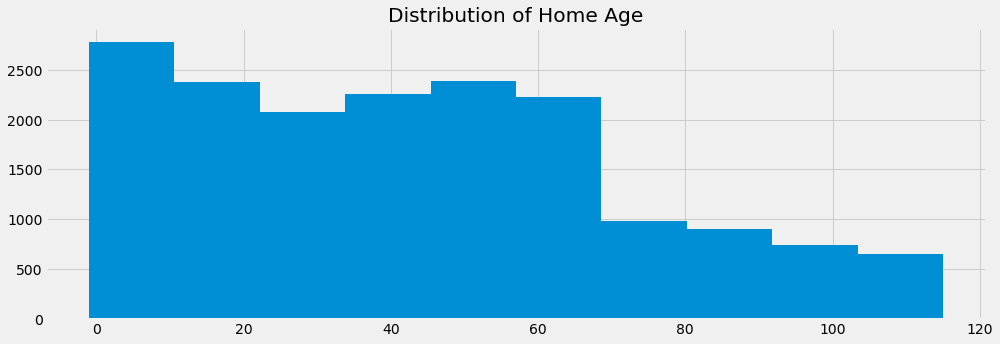

In [1437]:
#create new column
df_scrub['home_age'] = df_scrub['yr_sold'] - df_scrub['yr_built']
#plot distribution
fig, ax = plt.subplots(figsize=(15,5))
df_scrub['home_age'].hist(ax=ax);
ax.set_title('Distribution of Home Age');

## Change Data Types

In [1438]:
#check data types
df_scrub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17389 entries, 0 to 21596
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             17389 non-null  int64         
 1   date           17389 non-null  datetime64[ns]
 2   price          17389 non-null  float64       
 3   bedrooms       17389 non-null  int64         
 4   bathrooms      17389 non-null  float64       
 5   sqft_living    17389 non-null  int64         
 6   sqft_lot       17389 non-null  int64         
 7   floors         17389 non-null  float64       
 8   waterfront     15474 non-null  float64       
 9   view           17340 non-null  float64       
 10  condition      17389 non-null  int64         
 11  grade          17389 non-null  int64         
 12  sqft_above     17389 non-null  int64         
 13  sqft_basement  17389 non-null  int64         
 14  yr_built       17389 non-null  int64         
 15  yr_renovated   1738

## Null Values

In [1439]:
#check for null values
df_scrub.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1915
view               49
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
basement            0
month_sold          0
renovated           0
yr_sold             0
home_age            0
dtype: int64

### `waterfront` Column

In [1440]:
#view values in waterfront column
df_scrub['waterfront'].value_counts(dropna=False)

0.0    15357
nan     1915
1.0      117
Name: waterfront, dtype: int64

> **ACTION: I will drop the rows where `waterfront` has a null value**

In [1441]:
#drop rows with null values in the waterfront column
df_scrub.dropna(subset=['waterfront'], inplace=True)
df_scrub['waterfront'].isna().sum()

0

In [1442]:
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 15474 many rows.


### `view` Column

In [1443]:
#view the values of the view column
df_scrub['view'].value_counts(dropna=False)

0.0    13947
2.0      666
3.0      339
1.0      242
4.0      235
nan       45
Name: view, dtype: int64

> **ACTION:**
> - I will drop the 39 null values

In [1444]:
#drop rows
df_scrub.dropna(subset=['view'], inplace=True)
df_scrub['view'].isna().sum()

0

In [1445]:
#check the view column
df_scrub['view'].value_counts(dropna=False)

0.0    13947
2.0      666
3.0      339
1.0      242
4.0      235
Name: view, dtype: int64

## Duplicates

### Duplicates for `id`

In [1446]:
#check for duplicates
duplicate_id = df_scrub.loc[df_scrub.duplicated(subset='id', keep=False) == True].sort_values('id').head(50)
duplicate_id

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age
11421,109200390,2014-08-20,"245,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,...,1980,0.0,98023,47.2977,-122.367,1830,6956,0,8,0,2014,34
11422,109200390,2014-10-20,"250,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,...,1980,0.0,98023,47.2977,-122.367,1830,6956,0,10,0,2014,34
7785,251300110,2014-07-31,"225,000.0",3,2.25,2510,12013,2.0,0.0,0.0,3,8,...,1988,0.0,98003,47.3473,-122.314,1870,8017,0,7,0,2014,26
7786,251300110,2015-01-14,"358,000.0",3,2.25,2510,12013,2.0,0.0,0.0,3,8,...,1988,0.0,98003,47.3473,-122.314,1870,8017,0,1,0,2015,27
9225,302000375,2014-08-14,"169,100.0",3,2.0,1050,18304,1.0,0.0,0.0,4,7,...,1953,0.0,98001,47.3206,-122.26899999999999,1690,15675,0,8,0,2014,61
9226,302000375,2015-05-06,"250,000.0",3,2.0,1050,18304,1.0,0.0,0.0,4,7,...,1953,0.0,98001,47.3206,-122.26899999999999,1690,15675,0,5,0,2015,62
7171,526059224,2014-09-23,"260,000.0",4,1.75,1650,7276,1.0,0.0,0.0,3,7,...,1977,0.0,98011,47.7721,-122.206,1840,8550,1,9,0,2014,37
7172,526059224,2015-02-06,"470,000.0",4,1.75,1650,7276,1.0,0.0,0.0,3,7,...,1977,0.0,98011,47.7721,-122.206,1840,8550,1,2,0,2015,38
17367,641900050,2014-08-19,"335,000.0",4,2.25,2160,8817,1.0,0.0,0.0,3,7,...,1965,0.0,98133,47.7595,-122.35600000000001,1880,8817,1,8,0,2014,49
17368,641900050,2015-02-06,"499,950.0",4,2.25,2160,8817,1.0,0.0,0.0,3,7,...,1965,0.0,98133,47.7595,-122.35600000000001,1880,8817,1,2,0,2015,50


In [1447]:
#check duplicates
df_scrub.loc[df_scrub['id'] == 4139480200]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age
313,4139480200,2014-06-18,"1,380,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,...,1997,0.0,98006,47.5503,-122.102,3860,11244,1,6,0,2014,17
314,4139480200,2014-12-09,"1,400,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,...,1997,0.0,98006,47.5503,-122.102,3860,11244,1,12,0,2014,17


> **Duplicates in the `id` column seem to represent multiple sales of the same house. I will remove them because they aren't many and I am not sure how they will impact the model's prediction.**

In [1448]:
#remove duplicates
df_scrub.drop(duplicate_id.index, inplace=True)

## Column Drop

In [1449]:
#look at columns
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement', 'month_sold',
       'renovated', 'yr_sold', 'home_age'],
      dtype='object')

### The `sqft_basement` Column

The `sqft_basement` column can be eliminated now that I have a column which represents whether or not a house has a basement.

In [1450]:
#drop the sqft_basement column
df_scrub.drop(columns='sqft_basement', inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'basement', 'month_sold', 'renovated',
       'yr_sold', 'home_age'],
      dtype='object')

### The `sqft_living15` and `sqft_lot15` Columns

The `sqft_living15` and `sqft_lot15` columns do not seem to be relevant for predicting home listing prices. I will remove these.

In [1451]:
#drop columns
df_scrub.drop(columns=['sqft_living15','sqft_lot15'], inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'basement', 'month_sold', 'renovated', 'yr_sold', 'home_age'],
      dtype='object')

### `yr_renovated` Column

In [1452]:
#drop the yr_renovated column
df_scrub.drop(columns='yr_renovated', inplace=True)

## Outlier Removal

In [1453]:
#column data
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'zipcode', 'lat', 'long', 'basement',
       'month_sold', 'renovated', 'yr_sold', 'home_age'],
      dtype='object')

### `price` Column

(<AxesSubplot:title={'center':'Distribution of price'}>,
 <AxesSubplot:title={'center':'price vs price'}, xlabel='price', ylabel='price'>,
 <AxesSubplot:title={'center':'Boxplot of price'}>,
 count              15,379.0
 mean     542,229.3023603616
 std     373,300.67254935316
 min                82,000.0
 25%               322,000.0
 50%               450,000.0
 75%               645,000.0
 max             7,700,000.0
 Name: price, dtype: float64)

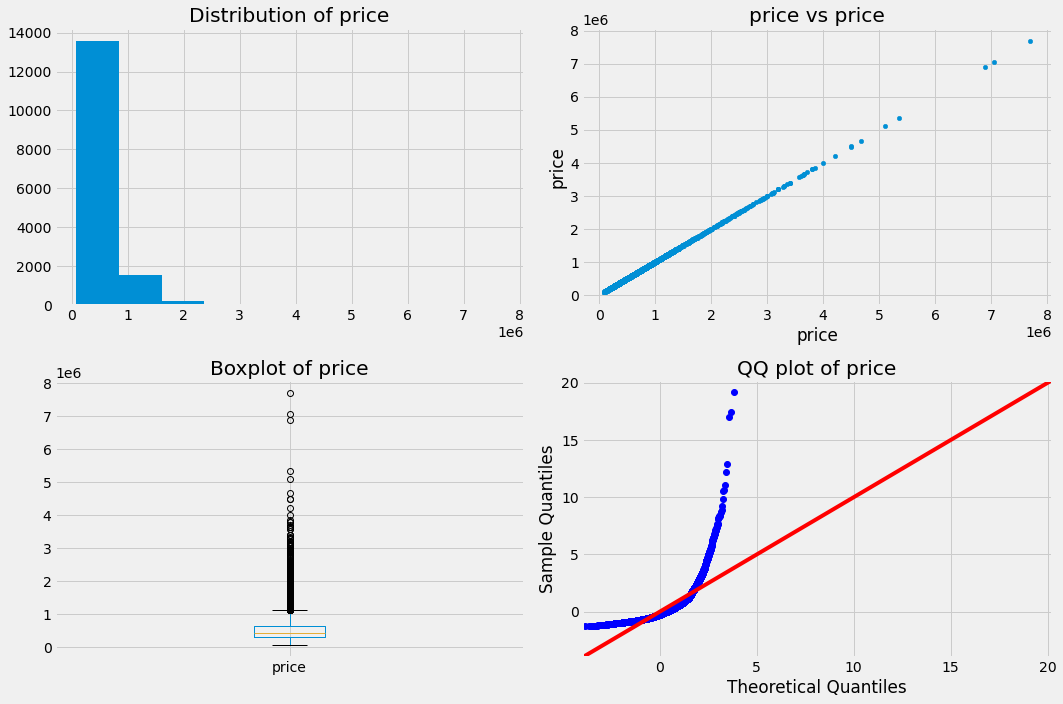

In [1454]:
#look at plots
get_plots(df_scrub, 'price', outlier='none')

> **Observations:**
> - Price has many outliers
> - Distribution is not normal

> **ACTION:**
> - I will keep outliers in at the moment since this is a dependent variable.

### `sqft_living` Column

(<AxesSubplot:title={'center':'Distribution of sqft_living'}>,
 <AxesSubplot:title={'center':'price vs sqft_living'}, xlabel='sqft_living', ylabel='price'>,
 <AxesSubplot:title={'center':'Boxplot of sqft_living'}>,
 count              15,379.0
 mean    2,087.1678912803172
 std       920.1061087890471
 min                   370.0
 25%                 1,430.0
 50%                 1,920.0
 75%                 2,550.0
 max                13,540.0
 Name: sqft_living, dtype: float64)

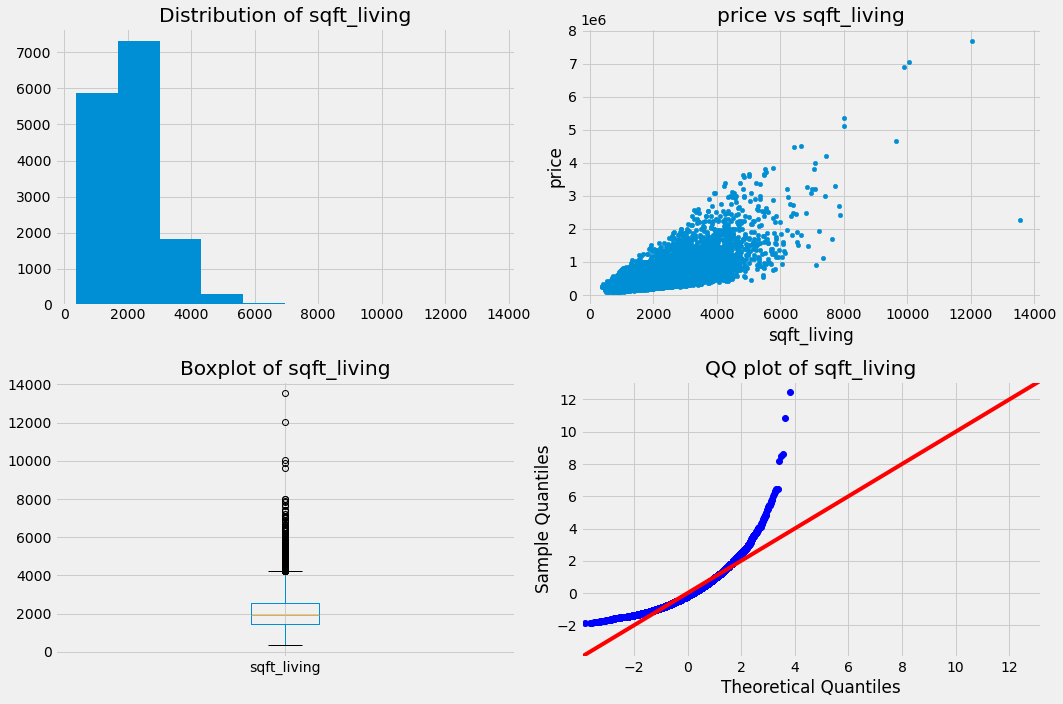

In [1455]:
#look at plots
get_plots(df_scrub,'sqft_living', outlier='none')

> **Observations:**
> - Many outliers
> - Distribution is not normal
> - Linear relationship with `price`

> **ACTION:**
> - I will remove the outliers based on iqr as the distribution is not normal

In [1456]:
#remove outliers based off iqr
q25 = df_scrub['sqft_living'].quantile(0.25)
q75 = df_scrub['sqft_living'].quantile(0.75)
iqr = q75-q25
upper_thresh = q75 + 1.5*iqr
lower_thresh = q25 - 1.5*iqr
df_scrub = df_scrub.loc[(df_scrub['sqft_living'] > lower_thresh) & 
                            (df_scrub['sqft_living'] < upper_thresh)]
print(f'The number of rows is now {len(df_scrub)}')

The number of rows is now 14946


### `bedrooms` Column

(<AxesSubplot:title={'center':'Distribution of bedrooms'}>,
 <AxesSubplot:title={'center':'price vs bedrooms'}, xlabel='bedrooms', ylabel='price'>,
 <AxesSubplot:title={'center':'Boxplot of bedrooms'}>,
 count             14,946.0
 mean     3.346647932557206
 std     0.9141472766027632
 min                    1.0
 25%                    3.0
 50%                    3.0
 75%                    4.0
 max                   33.0
 Name: bedrooms, dtype: float64)

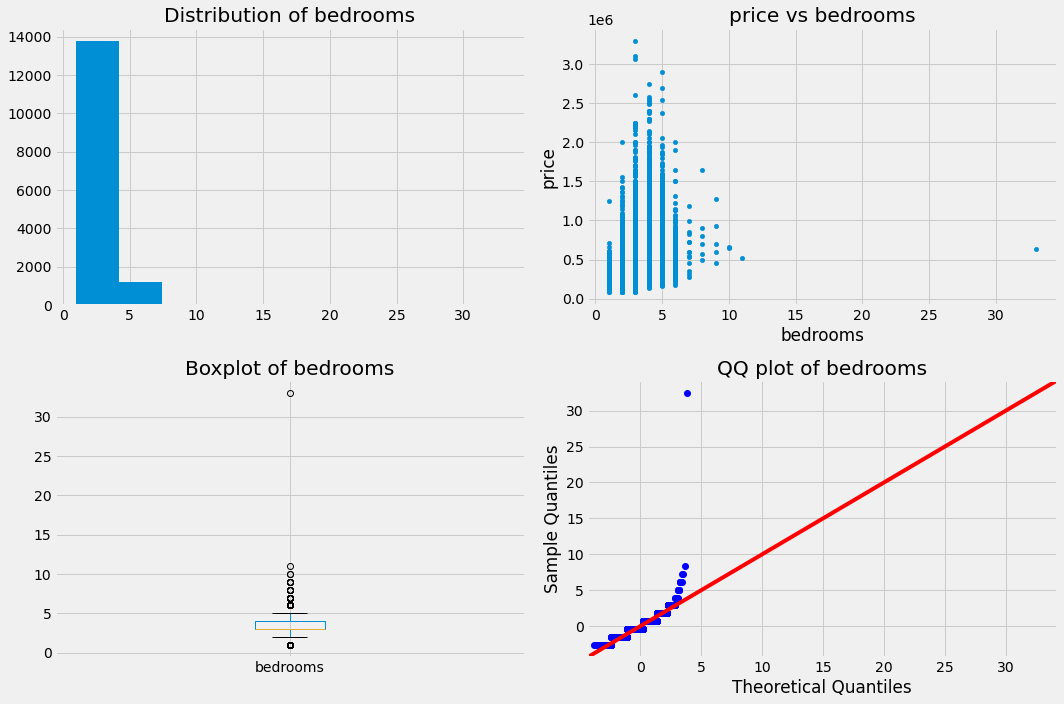

In [1457]:
#look at plots
get_plots(df_scrub, 'bedrooms',outlier='none')

> **Observations:**
> - 1 particularly large outlier

> **ACTION:**
> - I will remove the single outlier first.

In [1458]:
#remove single outlier
df_scrub = df_scrub.loc[(df_scrub['bedrooms'] < 20)]
print(f'The number of rows is now {len(df_scrub)}')

The number of rows is now 14945


(<AxesSubplot:title={'center':'Distribution of bedrooms'}>,
 <AxesSubplot:title={'center':'price vs bedrooms'}, xlabel='bedrooms', ylabel='price'>,
 <AxesSubplot:title={'center':'Boxplot of bedrooms'}>,
 count             14,945.0
 mean    3.3446637671462027
 std     0.8814057710609207
 min                    1.0
 25%                    3.0
 50%                    3.0
 75%                    4.0
 max                   11.0
 Name: bedrooms, dtype: float64)

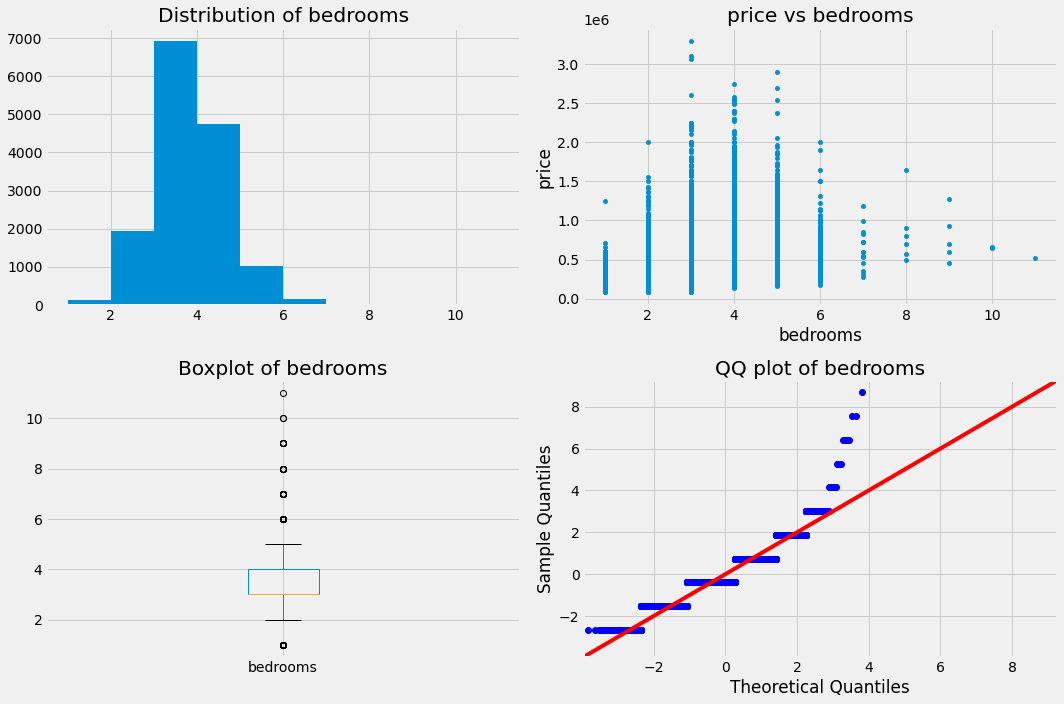

In [1459]:
#check plots again
get_plots(df_scrub, 'bedrooms',outlier='none')

### `sqft_lot` Column

The number of rows removed is 1644


(<AxesSubplot:title={'center':'Distribution of sqft_lot'}>,
 <AxesSubplot:title={'center':'price vs sqft_lot'}, xlabel='sqft_lot', ylabel='price'>,
 <AxesSubplot:title={'center':'Boxplot of sqft_lot'}>,
 count              14,945.0
 mean    14,507.906523921043
 std      39,963.12184882879
 min                   520.0
 25%                 5,000.0
 50%                 7,519.0
 75%                10,360.0
 max             1,651,359.0
 Name: sqft_lot, dtype: float64)

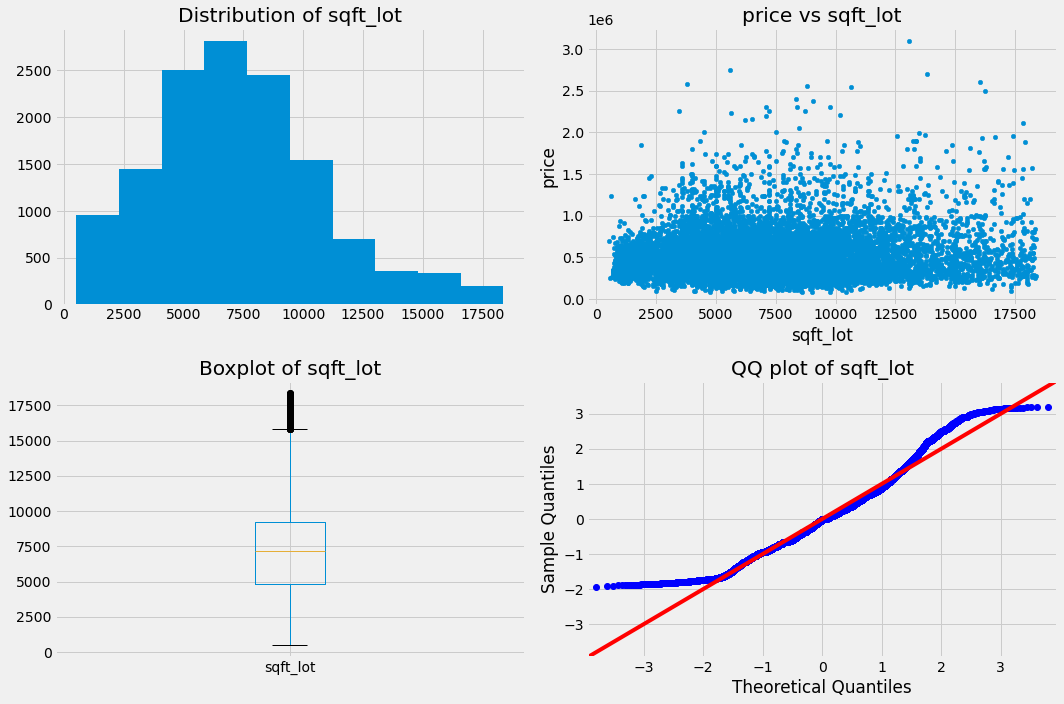

In [1460]:
#check plots
get_plots(df_scrub, 'sqft_lot',outlier='iqr')

> **Observations:**
> - Outliers skewing data

> **ACTION:**
> - Utilize the iqr to remove outliers

In [1461]:
#remove outliers based off iqr
q25 = df_scrub['sqft_lot'].quantile(0.25)
q75 = df_scrub['sqft_lot'].quantile(0.75)
iqr = q75-q25
upper_thresh = q75 + 1.5*iqr
lower_thresh = q25 - 1.5*iqr
df_scrub = df_scrub.loc[(df_scrub['sqft_lot'] > lower_thresh) & 
                            (df_scrub['sqft_lot'] < upper_thresh)]
print(f'The number of rows is now {len(df_scrub)}')

The number of rows is now 13301


(<AxesSubplot:title={'center':'Distribution of sqft_lot'}>,
 <AxesSubplot:title={'center':'price vs sqft_lot'}, xlabel='sqft_lot', ylabel='price'>,
 <AxesSubplot:title={'center':'Boxplot of sqft_lot'}>,
 count             13,301.0
 mean    7,250.690699947372
 std     3,486.962790182275
 min                  520.0
 25%                4,850.0
 50%                7,200.0
 75%                9,231.0
 max               18,360.0
 Name: sqft_lot, dtype: float64)

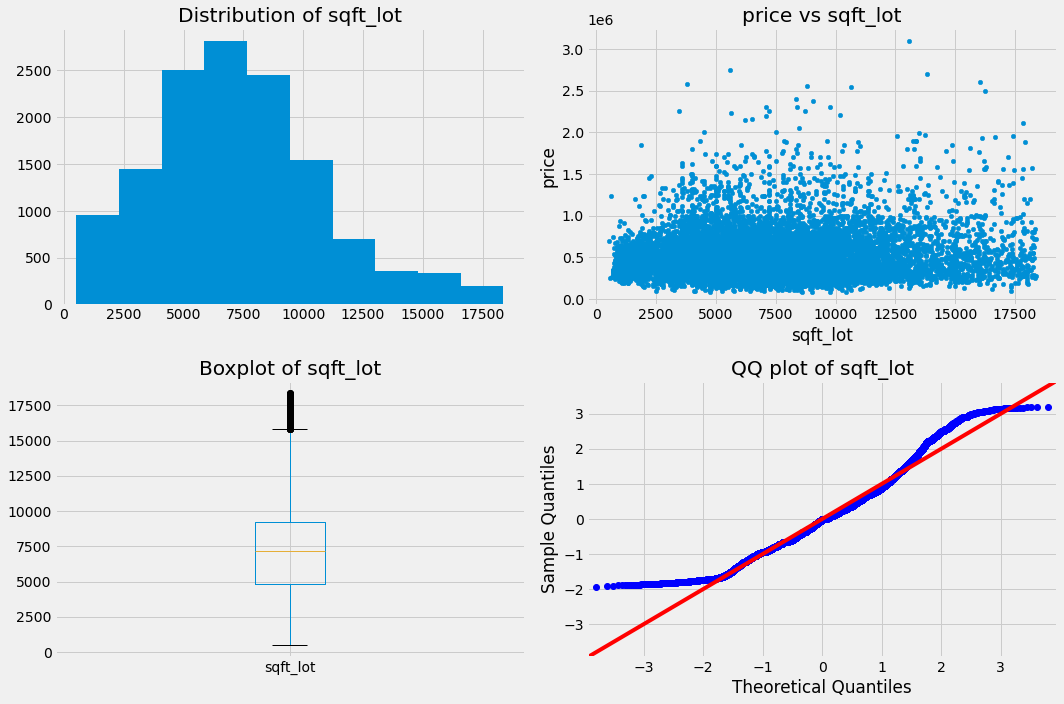

In [1462]:
#check the plots
get_plots(df_scrub, 'sqft_lot',outlier='none')

### `home_age` Column

(<AxesSubplot:title={'center':'Distribution of home_age'}>,
 <AxesSubplot:title={'center':'price vs home_age'}, xlabel='home_age', ylabel='price'>,
 <AxesSubplot:title={'center':'Boxplot of home_age'}>,
 count             13,301.0
 mean    44.142019397037814
 std      30.04088532950345
 min                   -1.0
 25%                   17.0
 50%                   42.0
 75%                   64.0
 max                  115.0
 Name: home_age, dtype: float64)

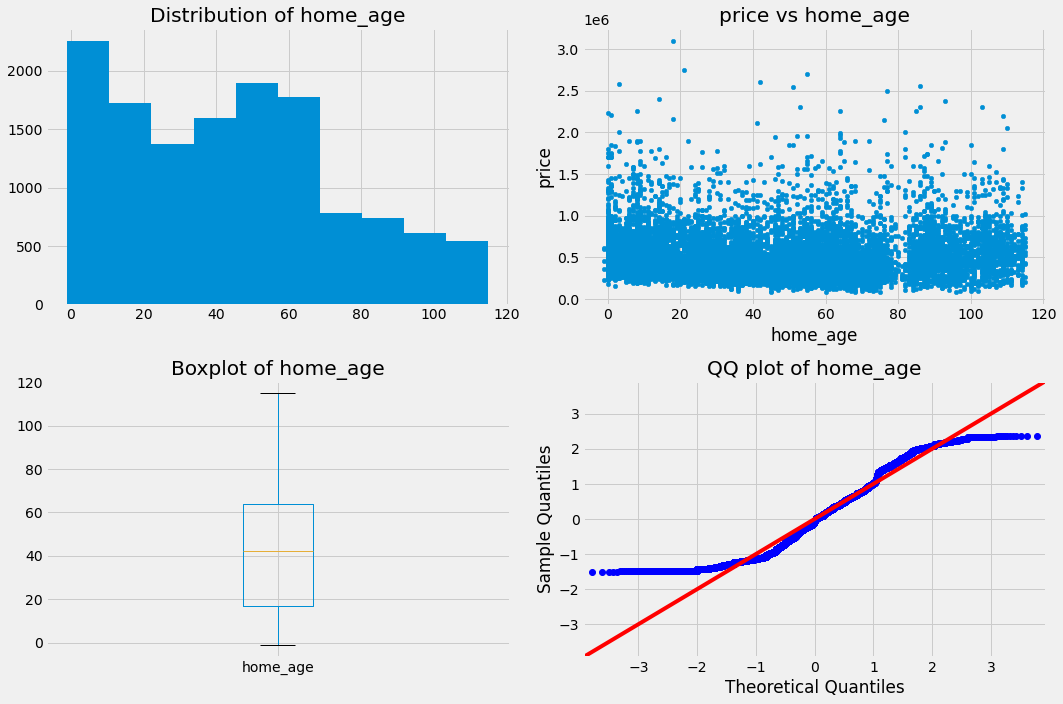

In [1463]:
#check the plots
get_plots(df_scrub, 'home_age',outlier='none')

In [1464]:
#view rows with home_age < 0
df_scrub.loc[df_scrub['home_age'] < 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,month_sold,renovated,yr_sold,home_age
7519,9520900210,2014-12-31,"614,285.0",5,2.75,2730,6401,2.0,0.0,0.0,3,8,2730,2015,98072,47.7685,-122.16,0,12,0,2014,-1
19789,9126100765,2014-08-01,"455,000.0",3,1.75,1320,1014,3.0,0.0,0.0,3,9,1320,2015,98122,47.6047,-122.305,0,8,0,2014,-1
20754,9310300160,2014-08-28,"357,000.0",5,2.5,2990,9240,2.0,0.0,0.0,3,8,2990,2015,98133,47.7384,-122.348,0,8,0,2014,-1
20836,1257201420,2014-07-09,"595,000.0",4,3.25,3730,4560,2.0,0.0,0.0,3,9,2760,2015,98103,47.6725,-122.33,1,7,0,2014,-1
20947,6058600220,2014-07-31,"230,000.0",3,1.5,1040,1264,2.0,0.0,0.0,3,9,900,2015,98144,47.5951,-122.301,1,7,0,2014,-1


> **Observations:**
> - There are 5 homes where the sale date is before the yr_built

> **ACTION:**
> - I will remove these homes

In [1465]:
#remove the rows
df_scrub.drop(df_scrub.loc[df_scrub['home_age'] < 0].index, inplace=True)
print(f'The number of rows now is {len(df_scrub)}.')

The number of rows now is 13296.


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## State of Dataframe

In [1466]:
#state of the dataframe
display(df_scrub.iloc[:10,:20], df_scrub.shape)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,month_sold,renovated
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,98125,47.721000000000004,-122.319,1,12,1
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,1965,98136,47.5208,-122.39299999999999,1,12,0
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,1987,98074,47.6168,-122.045,0,2,0
8,2414600126,2015-04-15,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,1050,1960,98146,47.5123,-122.337,1,4,0
9,3793500160,2015-03-12,"323,000.0",3,2.5,1890,6560,2.0,0.0,0.0,3,7,1890,2003,98038,47.3684,-122.031,0,3,0
11,9212900260,2014-05-27,"468,000.0",2,1.0,1160,6000,1.0,0.0,0.0,4,7,860,1942,98115,47.69,-122.292,1,5,0
13,6054650070,2014-10-07,"400,000.0",3,1.75,1370,9680,1.0,0.0,0.0,4,7,1370,1977,98074,47.6127,-122.045,0,10,0
14,1175000570,2015-03-12,"530,000.0",5,2.0,1810,4850,1.5,0.0,0.0,3,7,1810,1900,98107,47.67,-122.39399999999999,0,3,0
15,9297300055,2015-01-24,"650,000.0",4,3.0,2950,5000,2.0,0.0,3.0,3,9,1980,1979,98126,47.5714,-122.375,1,1,0
16,1875500060,2014-07-31,"395,000.0",3,2.0,1890,14040,2.0,0.0,0.0,3,7,1890,1994,98019,47.7277,-121.962,0,7,0


(13296, 22)

# Explore

I will now explore the dataset after initial scrubbing. I will investigate linearity, multicollinearity and homoscedasticity and correct any issues before modeling.

> **ACTION: I will create a copy of the scrub dataframe to explore the data.**

In [1467]:
#create a copy of the scrub dataframe
df_explore = df_scrub.copy()
df_explore

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,month_sold,renovated,yr_sold,home_age
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,98125,47.721000000000004,-122.319,1,12,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,1965,98136,47.5208,-122.39299999999999,1,12,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,1987,98074,47.6168,-122.045,0,2,0,2015,28
8,2414600126,2015-04-15,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,1050,1960,98146,47.5123,-122.337,1,4,0,2015,55
9,3793500160,2015-03-12,"323,000.0",3,2.5,1890,6560,2.0,0.0,0.0,3,7,1890,2003,98038,47.3684,-122.031,0,3,0,2015,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2015-02-19,"475,000.0",3,2.5,1310,1294,2.0,0.0,0.0,3,8,1180,2008,98116,47.5773,-122.40899999999999,1,2,0,2015,7
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,2009,98103,47.6993,-122.346,0,5,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,2014,98146,47.5107,-122.36200000000001,0,2,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,2009,98144,47.5944,-122.29899999999999,0,6,0,2014,5


## Linearity

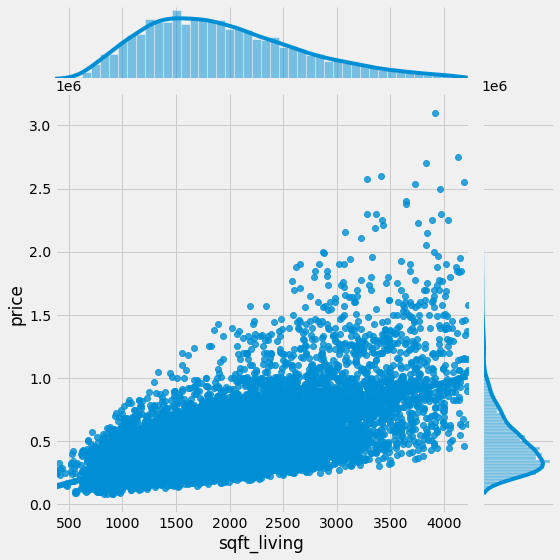

In [1468]:
sns.jointplot(data=df_explore, x='sqft_living', y='price', height=8, kind='reg')

> **Observations:**
> - `sqft_living` shows linearity with `price`
> - `sqft_above` shows linearity with `price`
> - All other columns are non-linear with `price`

## Multicollinearity

I want to check to see if the independent variables are truly independent from each other by checking for multicollinearity.

### Two Variable Multicollinearity Check

In [1469]:
#remove lat and long columns
df_explore.drop(columns=['lat','long'], inplace=True)

<AxesSubplot:>

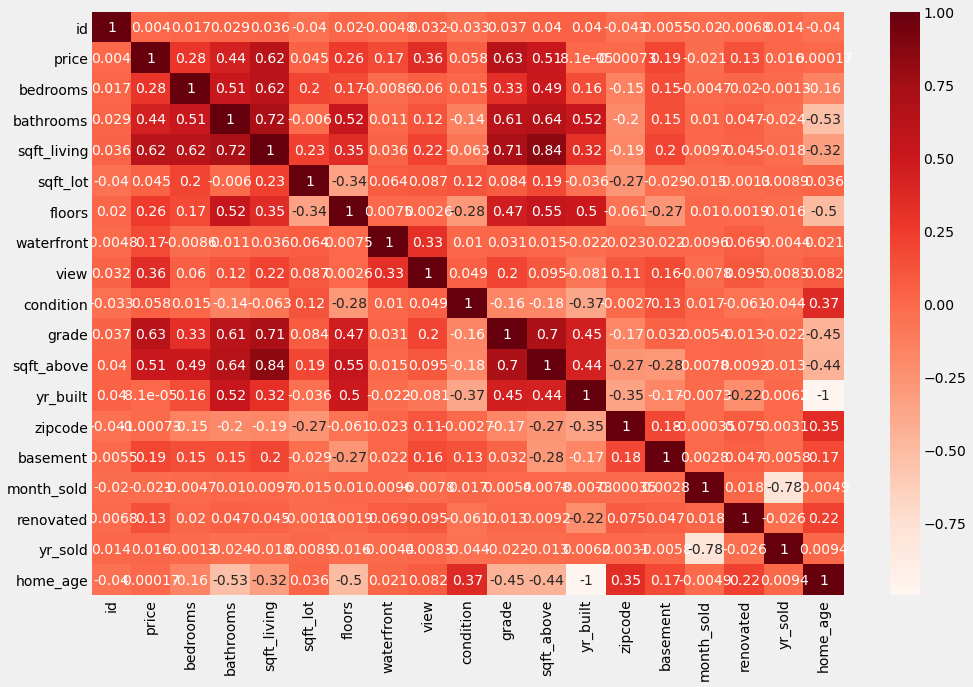

In [1470]:
#create and plot correlations
corr = df_explore.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, cmap='Reds', annot=True, ax=ax)

> **ACTION: Remove `sqft_above` as it correlates very closesly with `sqft_living`**

In [1471]:
#remove sqft_above
df_explore.drop(columns='sqft_above', inplace=True)

<AxesSubplot:>

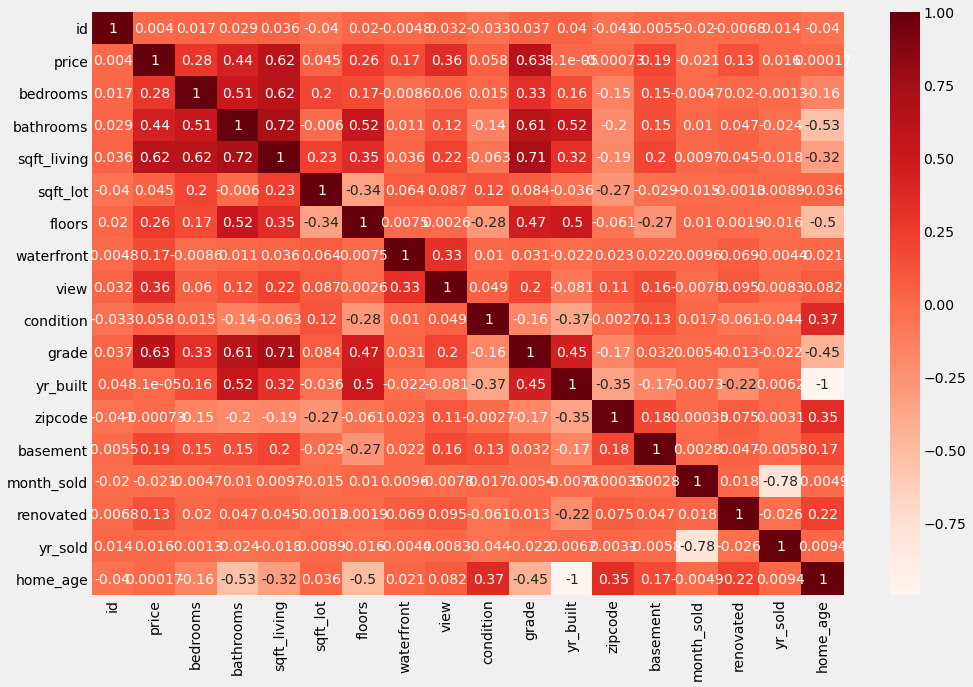

In [1472]:
corr = df_explore.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, cmap='Reds', annot=True, ax=ax)

> **There are no more variables which correlate above .75, therefore, variables are now considered independent.**

## Exploratory Questions

### khg

Home sale price over time

average sales price by zipcode

# Model

In [1473]:
#create a copy of the explore dataframe
df_model = df_explore.copy()
df_model

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,basement,month_sold,renovated,yr_sold,home_age
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1951,98125,1,12,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1965,98136,1,12,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1987,98074,0,2,0,2015,28
8,2414600126,2015-04-15,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,1960,98146,1,4,0,2015,55
9,3793500160,2015-03-12,"323,000.0",3,2.5,1890,6560,2.0,0.0,0.0,3,7,2003,98038,0,3,0,2015,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2015-02-19,"475,000.0",3,2.5,1310,1294,2.0,0.0,0.0,3,8,2008,98116,1,2,0,2015,7
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,2009,98103,0,5,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2014,98146,0,2,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,2009,98144,0,6,0,2014,5


## Model Preprocessing

### Column Drop

#### `yr_built` Column

In [1474]:
#drop the yr_built column
df_model.drop(columns='yr_built', inplace=True)

#### `id` Column

In [1475]:
#drop the id column
df_model.drop(columns='id', inplace=True)

#### `date` Column

In [1476]:
#drop the date column
df_model.drop(columns='date', inplace=True)

#### `floors` Column

In [1477]:
#drop the floors column
df_model.drop(columns='floors', inplace=True)

#### `yr_sold` Column

In [1478]:
#drop the yr_sold column
df_model.drop(columns='yr_sold', inplace=True)

In [1479]:
#view the dataframe
df_model

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,zipcode,basement,month_sold,renovated,home_age
1,"538,000.0",3,2.25,2570,7242,0.0,0.0,3,7,98125,1,12,1,63
3,"604,000.0",4,3.0,1960,5000,0.0,0.0,5,7,98136,1,12,0,49
4,"510,000.0",3,2.0,1680,8080,0.0,0.0,3,8,98074,0,2,0,28
8,"229,500.0",3,1.0,1780,7470,0.0,0.0,3,7,98146,1,4,0,55
9,"323,000.0",3,2.5,1890,6560,0.0,0.0,3,7,98038,0,3,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,"475,000.0",3,2.5,1310,1294,0.0,0.0,3,8,98116,1,2,0,7
21592,"360,000.0",3,2.5,1530,1131,0.0,0.0,3,8,98103,0,5,0,5
21593,"400,000.0",4,2.5,2310,5813,0.0,0.0,3,8,98146,0,2,0,1
21594,"402,101.0",2,0.75,1020,1350,0.0,0.0,3,7,98144,0,6,0,5


## Normalization

I am going to normalize the data values since it will help understand the model coefficients better in how they predict the dependent variable `price`.

In [1480]:
#set the independent and dependent columns
outcome = 'price'
predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
          'view', 'condition', 'grade', 'basement', 'month_sold', 
          'renovated', 'home_age']

In [1481]:
#normalize the data
for col in predictors:
    df_model[col] = (df_model[col] - df_model[col].mean())/df_model[col].std()
df_model.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,zipcode,basement,month_sold,renovated,home_age
1,"538,000.0",-0.3746315344566114,0.27207989326860416,0.8472001520386667,-0.0027896665000462077,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,98125,1.246735716349132,1.7382359445502173,4.976502696327879,0.6273272697162999
3,"604,000.0",0.7574368478468217,1.327894931958951,0.01985840130930996,-0.645807557481764,-0.05827276124012079,-0.2713630149718337,2.4197722317752004,-0.5195042815788686,98136,1.246735716349132,1.7382359445502173,-0.20092921684704113,0.16118537001540603
4,"510,000.0",-0.3746315344566114,-0.07985845296151142,-0.35990502525498497,0.23755332754218372,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,98074,-0.8020342854526303,-1.4641452552197274,-0.20092921684704113,-0.5380274795359348
8,"229,500.0",-0.3746315344566114,-1.4876118378819738,-0.22427523005345107,0.06260198343029798,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,98146,1.246735716349132,-0.8236690152657385,-0.20092921684704113,0.3609604698872177
9,"323,000.0",-0.3746315344566114,0.6240182394987198,-0.07508245533176378,-0.19839100532677748,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,98038,-0.8020342854526303,-1.143907135242733,-0.20092921684704113,-1.0707610791940991


## OHE Columns

I will determine which columns have categorical data and also which columns need to be one-hot encoded in order to be compatible with the model.

In [1482]:
#check column names
df_model.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'waterfront', 'view', 'condition', 'grade', 'zipcode', 'basement',
       'month_sold', 'renovated', 'home_age'],
      dtype='object')

In [1483]:
#check data types of columns
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13296 entries, 1 to 21596
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        13296 non-null  float64
 1   bedrooms     13296 non-null  float64
 2   bathrooms    13296 non-null  float64
 3   sqft_living  13296 non-null  float64
 4   sqft_lot     13296 non-null  float64
 5   waterfront   13296 non-null  float64
 6   view         13296 non-null  float64
 7   condition    13296 non-null  float64
 8   grade        13296 non-null  float64
 9   zipcode      13296 non-null  int64  
 10  basement     13296 non-null  float64
 11  month_sold   13296 non-null  float64
 12  renovated    13296 non-null  float64
 13  home_age     13296 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.5 MB


The number of rows removed is 0


(<AxesSubplot:title={'center':'Distribution of zipcode'}>,
 <AxesSubplot:title={'center':'price vs zipcode'}, xlabel='zipcode', ylabel='price'>,
 <AxesSubplot:title={'center':'Boxplot of zipcode'}>,
 count             13,296.0
 mean    98,080.79625451264
 std      53.88542233655801
 min               98,001.0
 25%               98,033.0
 50%               98,074.0
 75%               98,118.0
 max               98,199.0
 Name: zipcode, dtype: float64)

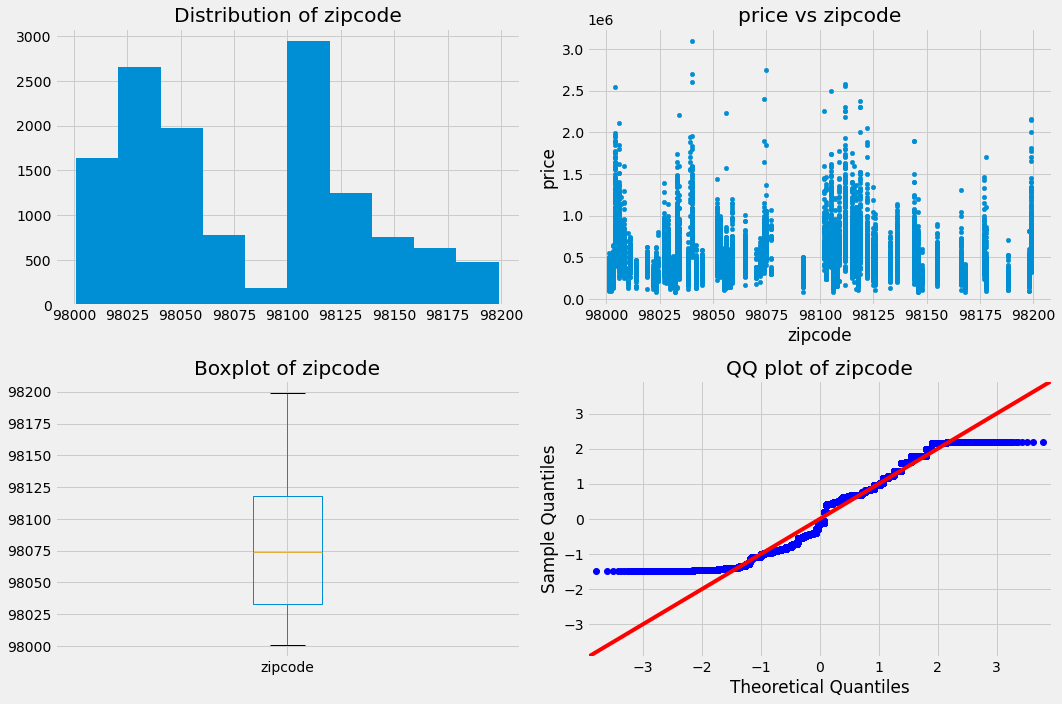

In [1484]:
#invvestigate each column
get_plots(df_model,'zipcode')

> **Observations:**
> - `zipcode` is categorical and needs to be hot-one encoded before putting into the model.

### `zipcode` OHE

In [1485]:
#fit the data
cat_zipcode = ['zipcode']
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_model[cat_zipcode])

OneHotEncoder(drop='first', sparse=False)

In [1486]:
#transform the data
ohe_vars = encoder.transform(df_model[cat_zipcode])
ohe_vars

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1487]:
#get the features
encoder.get_feature_names(cat_zipcode)

array(['zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', '

In [1488]:
#convert to dataframe
df_cat_zipcode = pd.DataFrame(ohe_vars, columns=encoder.get_feature_names(cat_zipcode), index=df_model.index)
df_cat_zipcode

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,...,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1489]:
#concat original dataframe to zipcode dataframe
df_model = pd.concat([df_model.drop('zipcode', axis=1), df_cat_zipcode], axis=1)
df_model

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,basement,month_sold,renovated,...,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
1,"538,000.0",-0.3746315344566114,0.27207989326860416,0.8472001520386667,-0.0027896665000462077,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,1.246735716349132,1.7382359445502173,4.976502696327879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"604,000.0",0.7574368478468217,1.327894931958951,0.01985840130930996,-0.645807557481764,-0.05827276124012079,-0.2713630149718337,2.4197722317752004,-0.5195042815788686,1.246735716349132,1.7382359445502173,-0.20092921684704113,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"510,000.0",-0.3746315344566114,-0.07985845296151142,-0.35990502525498497,0.23755332754218372,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,-0.8020342854526303,-1.4641452552197274,-0.20092921684704113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"229,500.0",-0.3746315344566114,-1.4876118378819738,-0.22427523005345107,0.06260198343029798,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,1.246735716349132,-0.8236690152657385,-0.20092921684704113,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,"323,000.0",-0.3746315344566114,0.6240182394987198,-0.07508245533176378,-0.19839100532677748,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,-0.8020342854526303,-1.143907135242733,-0.20092921684704113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,"475,000.0",-0.3746315344566114,0.6240182394987198,-0.8617352675006604,-1.7087086743320075,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,1.246735716349132,-1.4641452552197274,-0.20092921684704113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21592,"360,000.0",-0.3746315344566114,0.6240182394987198,-0.5633497180572858,-1.7554579679225606,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,-0.8020342854526303,-0.5034308952887441,-0.20092921684704113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,"400,000.0",0.7574368478468217,0.6240182394987198,0.4945626845146786,-0.41263470049329987,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,-0.8020342854526303,-1.4641452552197274,-0.20092921684704113,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,"402,101.0",-1.5066999167600446,-1.8395501841120894,-1.2550616735851088,-1.6926475673315722,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,-0.8020342854526303,-0.18319277531174954,-0.20092921684704113,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Multicollinearity

In [1176]:
#run VIF test 
# vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# list(zip(x_cols, vif))

## Model Creation

In [1490]:
#view the dataframe
df_model

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,basement,month_sold,renovated,...,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
1,"538,000.0",-0.3746315344566114,0.27207989326860416,0.8472001520386667,-0.0027896665000462077,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,1.246735716349132,1.7382359445502173,4.976502696327879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"604,000.0",0.7574368478468217,1.327894931958951,0.01985840130930996,-0.645807557481764,-0.05827276124012079,-0.2713630149718337,2.4197722317752004,-0.5195042815788686,1.246735716349132,1.7382359445502173,-0.20092921684704113,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"510,000.0",-0.3746315344566114,-0.07985845296151142,-0.35990502525498497,0.23755332754218372,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,-0.8020342854526303,-1.4641452552197274,-0.20092921684704113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"229,500.0",-0.3746315344566114,-1.4876118378819738,-0.22427523005345107,0.06260198343029798,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,1.246735716349132,-0.8236690152657385,-0.20092921684704113,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,"323,000.0",-0.3746315344566114,0.6240182394987198,-0.07508245533176378,-0.19839100532677748,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,-0.8020342854526303,-1.143907135242733,-0.20092921684704113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,"475,000.0",-0.3746315344566114,0.6240182394987198,-0.8617352675006604,-1.7087086743320075,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,1.246735716349132,-1.4641452552197274,-0.20092921684704113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21592,"360,000.0",-0.3746315344566114,0.6240182394987198,-0.5633497180572858,-1.7554579679225606,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,-0.8020342854526303,-0.5034308952887441,-0.20092921684704113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,"400,000.0",0.7574368478468217,0.6240182394987198,0.4945626845146786,-0.41263470049329987,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,0.4595643120246233,-0.8020342854526303,-1.4641452552197274,-0.20092921684704113,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,"402,101.0",-1.5066999167600446,-1.8395501841120894,-1.2550616735851088,-1.6926475673315722,-0.05827276124012079,-0.2713630149718337,-0.6364918124618156,-0.5195042815788686,-0.8020342854526303,-0.18319277531174954,-0.20092921684704113,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1499]:
#set up model parameters
outcome = 'mpg'
predictors = df_model.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [1501]:
predictors_int = sm.add_constant(predictors)
model = sm.OLS(df_model['price'],predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     758.7
Date:                Mon, 12 Apr 2021   Prob (F-statistic):               0.00
Time:                        23:56:05   Log-Likelihood:            -1.7359e+05
No. Observations:               13296   AIC:                         3.473e+05
Df Residuals:                   13214   BIC:                         3.480e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.089e+05   7928.186     38.964      0.000    2.93e+05    3.24e+05
bedrooms       -1.33e+04   1332.201     -9.985      0.000   -1.59e+04   -1.07e+04
bathrooms      9319.0938   1712.336      5.442      0.000    5962.669    1.27e+04
sqft_living    1.067e+05   2004.327     53.244      0.000    1.03e+05    1.11e+05
sqft_lot       1.065e+04   1366.690      7.795      0.000    7973.805    1.33e+04
waterfront     2.906e+04   1064.497     27.301      0.000     2.7e+04    3.11e+04
view           3.512e+04   1131.624     31.032      0.000    3.29e+04    3.73e+04
condition      1.667e+04   1132.102     14.724      0.000    1.44e+04    1.89e+04
grade           6.37e+04   1714.631     37.150      0.000    6.03e+04    6.71e+04
basement      -1.329e+04   1131.864    -11.738      0.000   -1.55e+04   -1.11e+04
month_sold    -9231.7403    988.574     -9.338      0.000   -1.12e+04   -7293.993
renovated      6758.9659   1060.744      6.372      0.000    4679.755    8838.176
home_age         1.9e+04   1715.424     11.079      0.000    1.56e+04    2.24e+04
zipcode_98002  2.369e+04   1.23e+04      1.934      0.053    -324.799    4.77e+04
zipcode_98003 -6865.7653   1.12e+04     -0.612      0.541   -2.89e+04    1.51e+04
zipcode_98004  6.619e+05   1.21e+04     54.661      0.000    6.38e+05    6.86e+05
zipcode_98005   3.21e+05   1.45e+04     22.215      0.000    2.93e+05    3.49e+05
zipcode_98006  2.617e+05   1.05e+04     24.863      0.000    2.41e+05    2.82e+05
zipcode_98007  2.427e+05   1.41e+04     17.223      0.000    2.15e+05     2.7e+05
zipcode_98008  2.369e+05   1.14e+04     20.816      0.000    2.15e+05    2.59e+05
zipcode_98010  1.171e+05   2.25e+04      5.197      0.000     7.3e+04    1.61e+05
zipcode_98011  1.343e+05    1.3e+04     10.326      0.000    1.09e+05     1.6e+05
zipcode_98014  1.138e+05   2.19e+04      5.198      0.000    7.09e+04    1.57e+05
zipcode_98019   8.07e+04   1.43e+04      5.636      0.000    5.26e+04    1.09e+05
zipcode_98022  2801.7089   1.36e+04      0.206      0.837   -2.39e+04    2.95e+04
zipcode_98023  -2.42e+04      1e+04     -2.413      0.016   -4.39e+04   -4539.513
zipcode_98024  1.371e+05   2.66e+04      5.157      0.000     8.5e+04    1.89e+05
zipcode_98027  2.287e+05   1.17e+04     19.530      0.000    2.06e+05    2.52e+05
zipcode_98028  1.219e+05   1.14e+04     10.661      0.000    9.95e+04    1.44e+05
zipcode_98029  2.174e+05   1.11e+04     19.635      0.000    1.96e+05    2.39e+05
zipcode_98030   530.3949   1.17e+04      0.045      0.964   -2.24e+04    2.34e+04
zipcode_98031  1.485e+04   1.15e+04      1.290      0.197   -7720.520    3.74e+04
zipcode_98032  3980.6184   1.43e+04      0.279      0.780    -2.4e+04     3.2e+04
zipcode_98033  3.357e+05   1.04e+04     32.186      0.000    3.15e+05    3.56e+05
zipcode_98034  2.007e+05   9823.521     20.427   